[![Fixel Algorithms](https://i.imgur.com/AqKHVZ0.png)](https://fixelalgorithms.gitlab.io/)

# cifar10-2d-convolution

## Image Classification with 2D Convolution (CIFAR 10)

> Notebook by:
> - Royi Avital RoyiAvital@fixelalgorithms.com

## Revision History

| Version | Date       | User        |Content / Changes                                                   |
|---------|------------|-------------|--------------------------------------------------------------------|
| 1.0.000 | 27/04/2024 | Royi Avital | First version                                                      |

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/AIProgram/2024_02/0086DeepLearningConv2DCifar10.ipynb)

In [2]:
# Import Packages

# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Machine Learning

# Deep Learning
import torch
import torch.nn            as nn
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchinfo
from torchmetrics.classification import MulticlassAccuracy
import torchvision

# Miscellaneous
import math
import os
from platform import python_version
import random
import time

# Typing
from typing import Callable, Dict, Generator, List, Optional, Self, Set, Tuple, Union

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter
from IPython import get_ipython
from IPython.display import HTML, Image
from IPython.display import display
from ipywidgets import Dropdown, FloatSlider, interact, IntSlider, Layout, SelectionSlider
from ipywidgets import interact

## Notations

* <font color='red'>(**?**)</font> Question to answer interactively.
* <font color='blue'>(**!**)</font> Simple task to add code for the notebook.
* <font color='green'>(**@**)</font> Optional / Extra self practice.
* <font color='brown'>(**#**)</font> Note / Useful resource / Food for thought.

Code Notations:

```python
someVar    = 2; #<! Notation for a variable
vVector    = np.random.rand(4) #<! Notation for 1D array
mMatrix    = np.random.rand(4, 3) #<! Notation for 2D array
tTensor    = np.random.rand(4, 3, 2, 3) #<! Notation for nD array (Tensor)
tuTuple    = (1, 2, 3) #<! Notation for a tuple
lList      = [1, 2, 3] #<! Notation for a list
dDict      = {1: 3, 2: 2, 3: 1} #<! Notation for a dictionary
oObj       = MyClass() #<! Notation for an object
dfData     = pd.DataFrame() #<! Notation for a data frame
dsData     = pd.Series() #<! Notation for a series
hObj       = plt.Axes() #<! Notation for an object / handler / function handler
```

### Code Exercise

 - Single line fill

 ```python
 vallToFill = ???
 ```

 - Multi Line to Fill (At least one)

 ```python
 # You need to start writing
 ????
 ```

 - Section to Fill

```python
#===========================Fill This===========================#
# 1. Explanation about what to do.
# !! Remarks to follow / take under consideration.
mX = ???

???
#===============================================================#
```

In [3]:
# Configuration
# %matplotlib inline

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

# Matplotlib default color palette
lMatPltLibclr = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# sns.set_theme() #>! Apply SeaBorn theme

runInGoogleColab = 'google.colab' in str(get_ipython())

# Improve performance by benchmarking
torch.backends.cudnn.benchmark = True

# Reproducibility
# torch.manual_seed(seedNum)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark     = False


In [4]:
# Constants

FIG_SIZE_DEF    = (8, 8)
ELM_SIZE_DEF    = 50
CLASS_COLOR     = ('b', 'r')
EDGE_COLOR      = 'k'
MARKER_SIZE_DEF = 10
LINE_WIDTH_DEF  = 2

D_CLASSES_CIFAR_10  = {0: 'Airplane', 1: 'Automobile', 2: 'Bird', 3: 'Cat', 4: 'Deer', 5: 'Dog', 6: 'Frog', 7: 'Horse', 8: 'Ship', 9: 'Truck'}
L_CLASSES_CIFAR_10  = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
T_IMG_SIZE_CIFAR_10 = (32, 32, 3)

DATA_FOLDER_PATH = 'Data'


In [5]:
# Download Auxiliary Modules for Google Colab
if runInGoogleColab:
    !wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/AIProgram/2024_02/DataManipulation.py
    !wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/AIProgram/2024_02/DataVisualization.py
    !wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/AIProgram/2024_02/DeepLearningPyTorch.py

In [6]:
# Courses Packages
import sys,os
sys.path.append('/home/vlad/utils')
from DataVisualization import PlotLabelsHistogram, PlotMnistImages
from DeepLearningPyTorch import NNMode, TrainModel


In [7]:
# General Auxiliary Functions

def AccuracyLogits( mScore: torch.Tensor, vY: torch.Tensor) -> float:
    
    vHatY = torch.argmax(mScore.detach(), dim = 1) #<! Logits -> Index (As SoftMax is monotonic)
    valAcc = torch.mean((vHatY == vY).float()).item()
    
    return valAcc


## CIFAR 10 Image Classification with 2D Convolution Net

This notebook shows the use of [`Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) layer.  
The 2D Convolution layer means there are 2 _degrees of freedom_ for the kernel movement.

This notebook applies image classification (Single label per image) on the [CIFAR 10](https://en.wikipedia.org/wiki/CIFAR-10) dataset.  

The notebook presents:

 * Building a 2D convolution based model which fits _Computer Vision_ tasks.
 * Use of [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html).
 * Use of [`torch.nn.BatchNorm2d`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d).

</br>

* <font color='brown'>(**#**)</font> Convolution is a _Linear Shift Invariant_ (LSI) operator. 
Hence it fits the task of processing and extracting features from images.
* <font color='brown'>(**#**)</font> While the convolution layer is LSI the whole net is not fue to Pool Layers, 
* <font color='brown'>(**#**)</font> One technique to make CNN not sensitive to shifts is by training it on a shifted data set.
* <font color='brown'>(**#**)</font> Modern CNN's are commonly attributed to [Yan LeCun](https://en.wikipedia.org/wiki/Yann_LeCun).  
  Yet, The first documented CNN is called _Neocognitron_ and attributed to [Kunihiko Fukushima](https://en.wikipedia.org/wiki/Kunihiko_Fukushima).
* <font color='brown'>(**#**)</font> For history see [Annotated History of Modern AI and Deep Learning](https://people.idsia.ch/~juergen/deep-learning-history.html) ([ArXiV Paper](https://arxiv.org/abs/2212.11279)).

In [8]:
# Parameters

# Data

# Model
dropP = 0.2 #<! Dropout Layer

# Training
batchSize   = 256
numWork     = 2 #<! Number of workers
nEpochs     = 30

# Visualization
numImg = 3


## Generate / Load Data

Load the [CIFAR 10 Data Set](https://en.wikipedia.org/wiki/CIFAR-10).  
It is composed of 60,000 RGB images of size `32x32` with 10 classes uniformly spread.

* <font color='brown'>(**#**)</font> The dataset is retrieved using [Torch Vision](https://pytorch.org/vision/stable/index.html)'s built in datasets.  


In [9]:
# Load Data

# PyTorch 
dsTrain = torchvision.datasets.CIFAR10(root = DATA_FOLDER_PATH, train = True,  download = True, transform = torchvision.transforms.ToTensor())
dsTest  = torchvision.datasets.CIFAR10(root = DATA_FOLDER_PATH, train = False, download = True, transform = torchvision.transforms.ToTensor())
lClasses  = dsTrain.classes


print(f'The training data set data shape: {dsTrain.data.shape}')
print(f'The test data set data shape: {dsTest.data.shape}')
print(f'The unique values of the labels: {np.unique(lClasses)}')

Files already downloaded and verified
Files already downloaded and verified
The training data set data shape: (50000, 32, 32, 3)
The test data set data shape: (10000, 32, 32, 3)
The unique values of the labels: ['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


* <font color='brown'>(**#**)</font> The dataset is indexible (Subscriptable). It returns a tuple of the features and the label.
* <font color='brown'>(**#**)</font> While data is arranged as `H x W x C` the transformer, when accessing the data, will convert it into `C x H x W`. 
* <font color='brown'>(**#**)</font> Data arrangement:
    * [`NHWC` vs. `NCHW` : A Memory Access Perspective on GPUs](https://scribe.rip/4e79bd3b1b54).
    * [Why Does PyTorch Prefer Using NCHW](https://discuss.pytorch.org/t/83637).
    * [Efficient PyTorch: Tensor Memory Format Matters](https://pytorch.org/blog/tensor-memory-format-matters).
    * [Accelerating PyTorch Vision Models with Channels Last on CPU](https://pytorch.org/blog/accelerating-pytorch-vision-models-with-channels-last-on-cpu).
* <font color='brown'>(**#**)</font> PyTorch worked on supporting `NxHxWxC`: [(Beta) Channels Last Memory Format in PyTorch](https://pytorch.org/tutorials/intermediate/memory_format_tutorial.html).

In [28]:
# Element of the Data Set

mX, valY = dsTrain[0]

print(f'The features shape: {mX.shape}')
print(f'The label value: {valY}')

The features shape: torch.Size([3, 32, 32])
The label value: 6


### Plot the Data

In [11]:
# Extract Data

tX = dsTrain.data #<! NumPy Tensor (NDarray)
mX = np.reshape(tX, (tX.shape[0], -1))
vY = dsTrain.targets #<! NumPy Vector


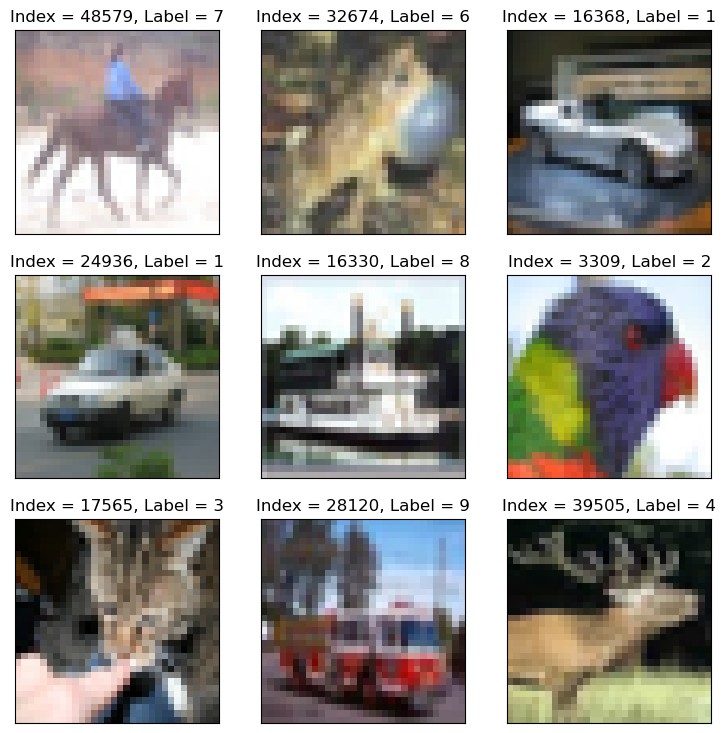

In [12]:
# Plot the Data

hF = PlotMnistImages(mX, vY, numImg, tuImgSize = T_IMG_SIZE_CIFAR_10)

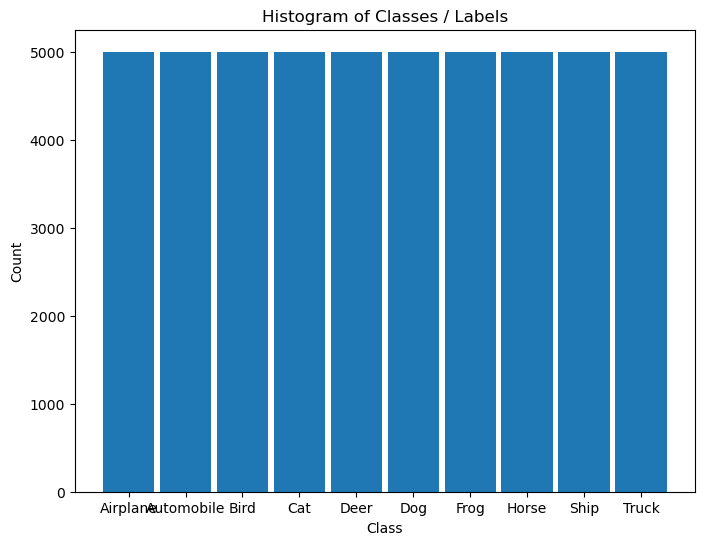

In [13]:
# Histogram of Labels

hA = PlotLabelsHistogram(vY, lClass = L_CLASSES_CIFAR_10)
plt.show()

## Pre Process Data

This section normalizes the data to have zero mean and unit variance per **channel**.  
It is required to calculate:

 * The average pixel value per channel.
 * The standard deviation per channel.

In [14]:
# Calculate the Standardization Parameters
vMean = np.mean(dsTrain.data / 255.0, axis = (0, 1, 2))
vStd  = np.std(dsTest.data / 255.0, axis = (0, 1, 2))

print('µ =', vMean)
print('σ =', vStd)

µ = [0.49139968 0.48215841 0.44653091]
σ = [0.24665252 0.24289226 0.26159238]


In [15]:
# Update Transformer

oDataTrns = torchvision.transforms.Compose([       #<! Chaining transformations
    torchvision.transforms.ToTensor(),             #<! Convert to Tensor (C x H x W), Normalizes into [0, 1] (https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html)
    torchvision.transforms.Normalize(vMean, vStd), #<! Normalizes the Data (https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html)
    ])

# Update the DS transformer
dsTrain.transform = oDataTrns
dsTest.transform  = oDataTrns

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


mx shape: torch.Size([3, 32, 32])


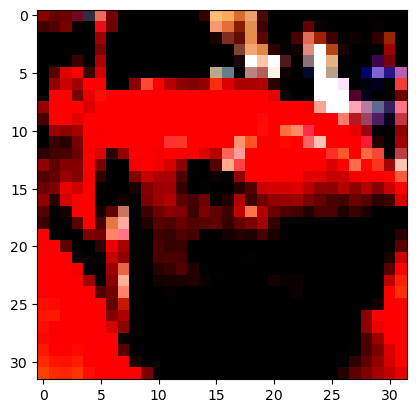

In [29]:
# "Normalized" Image

mX, valY = dsTrain[5]
print(f'mx shape: {mX.shape}')
hF, hA = plt.subplots()
hA.imshow(np.transpose(mX, (1, 2, 0)))
plt.show()

### Data Loaders

The dataloader is the functionality which loads the data into memory in batches.  
Its challenge is to bring data fast enough so the Hard Disk is not the training bottleneck.  
In order to achieve that, Multi Threading / Multi Process is used.

* <font color='brown'>(**#**)</font> The multi process, by the `num_workers` parameter is not working well _out of the box_ on Windows.  
  See [Errors When Using `num_workers > 0` in `DataLoader`](https://discuss.pytorch.org/t/97564), [On Windows `DataLoader` with `num_workers > 0` Is Slow](https://github.com/pytorch/pytorch/issues/12831).  
  A way to overcome it is to define the training loop as a function in a different module (File) and import it (https://discuss.pytorch.org/t/97564/4, https://discuss.pytorch.org/t/121588/21). 
* <font color='brown'>(**#**)</font> The `num_workers` should be set to the lowest number which feeds the GPU fast enough.  
  The idea is preserve as much as CPU resources to other tasks.
* <font color='brown'>(**#**)</font> On Windows keep the `persistent_workers` parameter to `True` (_Windows_ is slower on forking processes / threads).
* <font color='brown'>(**#**)</font> The Dataloader is a generator which can be looped on.
* <font color='brown'>(**#**)</font> In order to make it iterable it has to be wrapped with `iter()`.

In [17]:
# Data Loader

dlTrain  = torch.utils.data.DataLoader(dsTrain, shuffle = True, batch_size = 1 * batchSize, num_workers = numWork, persistent_workers = True)
dlTest   = torch.utils.data.DataLoader(dsTest, shuffle = False, batch_size = 2 * batchSize, num_workers = numWork, persistent_workers = True)


* <font color='red'>(**?**)</font> Why is the size of the batch twice as big for the test dataset?

In [18]:
# Iterate on the Loader
# The first batch.
tX, vY = next(iter(dlTrain)) #<! PyTorch Tensors

print(f'The batch features dimensions: {tX.shape}')
print(f'The batch labels dimensions: {vY.shape}')

The batch features dimensions: torch.Size([256, 3, 32, 32])
The batch labels dimensions: torch.Size([256])


In [30]:
# Looping
for ii, (tX, vY) in zip(range(1), dlTest): #<! https://stackoverflow.com/questions/36106712
    print(f'The batch features dimensions: {tX.shape}')     ## batch size will be 2 * batchSize
    print(f'The batch labels dimensions: {vY.shape}')

The batch features dimensions: torch.Size([512, 3, 32, 32])
The batch labels dimensions: torch.Size([512])


## Define the Model

The model is defined as a sequential model.

In [20]:
# Model
# Defining a sequential model.

numFeatures = np.prod(tX.shape[1:])

oModel = nn.Sequential(
        nn.Identity(),
        
        nn.Conv2d(in_channels = 3, out_channels = 30, kernel_size = 3, bias = False),   ## batch false due to use of bath normalization
        nn.BatchNorm2d(num_features = 30),
        nn.ReLU(),
        nn.Dropout2d(p = dropP),
        
        nn.Conv2d(in_channels = 30, out_channels = 60, kernel_size = 3, bias = False),
        nn.MaxPool2d(kernel_size = 2),
        nn.BatchNorm2d(num_features = 60),
        nn.ReLU(),
        nn.Dropout2d(p = dropP),
                
        nn.Conv2d(in_channels = 60,  out_channels = 120, kernel_size = 3, bias = False),
        nn.BatchNorm2d(num_features = 120),
        nn.ReLU(),
        nn.Dropout2d(p = dropP),
        
        nn.Conv2d(in_channels = 120, out_channels = 240, kernel_size = 3, bias = False),
        nn.BatchNorm2d(num_features = 240),
        nn.ReLU(),
        nn.Dropout2d(p = dropP),
        
        nn.Conv2d(in_channels = 240, out_channels = 500, kernel_size = 3, bias = False),
        nn.MaxPool2d(kernel_size = 2),
        nn.BatchNorm2d(num_features = 500),
        nn.ReLU(),
        
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Linear(500, len(L_CLASSES_CIFAR_10)),
    )

torchinfo.summary(oModel, tX.shape, col_names = ['kernel_size', 'output_size', 'num_params'], device = 'cpu') #<! Added `kernel_size`

Layer (type:depth-idx)                   Kernel Shape              Output Shape              Param #
Sequential                               --                        [256, 10]                 --
├─Identity: 1-1                          --                        [256, 3, 32, 32]          --
├─Conv2d: 1-2                            [3, 3]                    [256, 30, 30, 30]         810
├─BatchNorm2d: 1-3                       --                        [256, 30, 30, 30]         60
├─ReLU: 1-4                              --                        [256, 30, 30, 30]         --
├─Dropout2d: 1-5                         --                        [256, 30, 30, 30]         --
├─Conv2d: 1-6                            [3, 3]                    [256, 60, 28, 28]         16,200
├─MaxPool2d: 1-7                         2                         [256, 60, 14, 14]         --
├─BatchNorm2d: 1-8                       --                        [256, 60, 14, 14]         120
├─ReLU: 1-9                  

* <font color='red'>(**?**)</font> Why `in_channels = 3`?
* <font color='red'>(**?**)</font> Why `bias = False` in the convolution layers?
* <font color='red'>(**?**)</font> Could the _Batch Normalization_ layer be at the model's beginning as an alternative to data normalization?
* <font color='red'>(**?**)</font> What's the largest kernel size for `Conv2d` to be used after the last `MaxPool2d` layer?
* <font color='brown'>(**#**)</font> BN's `num_features` is required to know the number of parameters of the layer.
* <font color='brown'>(**#**)</font> For videos or other 4D dimensions data one could employ `Conv3d`.


* <font color='brown'>(**#**)</font> Guideline: The smaller the image gets, the deeper it is (More channels).   
  The intuition, the beginning of the model learns low level features (Small number), deeper learns combinations of features (Larger number).

In [21]:
# Run Model
# Apply a test run.

tX      = torch.randn(128, 3, 32, 32)
mLogits = oModel(tX) #<! Logit -> Prior to Sigmoid

print(f'The input dimensions: {tX.shape}')
print(f'The output (Logits) dimensions: {mLogits.shape}')

The input dimensions: torch.Size([128, 3, 32, 32])
The output (Logits) dimensions: torch.Size([128, 10])


* <font color='brown'>(**#**)</font> The [Logit Function](https://en.wikipedia.org/wiki/Logit) is the inverse of the [Sigmoid Function](https://en.wikipedia.org/wiki/Sigmoid_function).  
  It is commonly used to describe values in the range $\left( - \infty, \infty \right)$ which can be transformed into probabilities.

## Training Loop


### Train the Model

In [22]:
# Check GPU Availability

runDevice   = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #<! The 1st CUDA device
oModel      = oModel.to(runDevice) #<! Transfer model to device

In [23]:
# Set the Loss & Score

hL = nn.CrossEntropyLoss()
hS = MulticlassAccuracy(num_classes = len(L_CLASSES_CIFAR_10), average = 'micro') #<! See documentation for `macro` vs. `micro`
hS = hS.to(runDevice)

* <font color='blue'>(**!**)</font> Go through `AccuracyLogits()` as equivalent tp `micro` mode.

In [24]:
# Define Optimizer

oOpt = torch.optim.AdamW(oModel.parameters(), lr = 1e-3, betas = (0.9, 0.99), weight_decay = 1e-3) #<! Define optimizer

In [25]:
# Train the Model

oRunModel, lTrainLoss, lTrainScore, lValLoss, lValScore , _= TrainModel(oModel, dlTrain, dlTest, oOpt, nEpochs, hL, hS)


Epoch    1 / 30 | Train Loss:  1.624 | Val Loss:  1.242 | Train Score:  0.406 | Val Score:  0.555 | Epoch Time: 25.83 | <-- Checkpoint! |
Epoch    2 / 30 | Train Loss:  1.261 | Val Loss:  1.024 | Train Score:  0.548 | Val Score:  0.636 | Epoch Time: 13.48 | <-- Checkpoint! |
Epoch    3 / 30 | Train Loss:  1.084 | Val Loss:  0.947 | Train Score:  0.615 | Val Score:  0.668 | Epoch Time: 12.63 | <-- Checkpoint! |
Epoch    4 / 30 | Train Loss:  0.974 | Val Loss:  0.821 | Train Score:  0.656 | Val Score:  0.715 | Epoch Time: 12.91 | <-- Checkpoint! |
Epoch    5 / 30 | Train Loss:  0.886 | Val Loss:  0.741 | Train Score:  0.689 | Val Score:  0.743 | Epoch Time: 12.56 | <-- Checkpoint! |
Epoch    6 / 30 | Train Loss:  0.820 | Val Loss:  0.690 | Train Score:  0.714 | Val Score:  0.757 | Epoch Time: 12.56 | <-- Checkpoint! |
Epoch    7 / 30 | Train Loss:  0.767 | Val Loss:  0.648 | Train Score:  0.736 | Val Score:  0.776 | Epoch Time: 12.58 | <-- Checkpoint! |
Epoch    8 / 30 | Train Loss:  0.7

* <font color='red'>(**?**)</font> Why train results are worse than validation for 5-6 epochs?

### Results Analysis


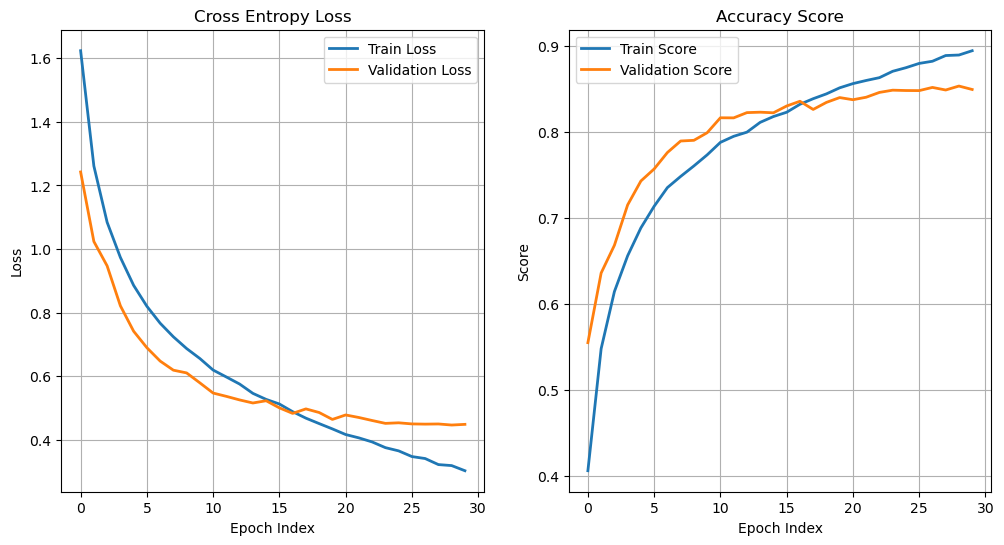

In [26]:
# Plot Results
hF, vHa = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))
vHa = vHa.flat

hA = vHa[0]
hA.plot(lTrainLoss, lw = 2, label = 'Train Loss')
hA.plot(lValLoss, lw = 2, label = 'Validation Loss')
hA.grid()
hA.set_title('Cross Entropy Loss')
hA.set_xlabel('Epoch Index')
hA.set_ylabel('Loss')
hA.legend();


hA = vHa[1]
hA.plot(lTrainScore, lw = 2, label = 'Train Score')
hA.plot(lValScore, lw = 2, label = 'Validation Score')
hA.grid()
hA.set_title('Accuracy Score')
hA.set_xlabel('Epoch Index')
hA.set_ylabel('Score')
hA.legend();
